In [2]:
import numpy as np
import pandas as pd
import linearsolve as ls
import matplotlib.pyplot as plt
plt.style.use('classic')
%matplotlib inline

# Exogenous Shocks in the New-Keynesian Model

In this notebook, we will compute impulse responses to exogenous shocks in the new-Keynesian model and interpret the results.

### Households

\begin{align}
C_t^{-\sigma} & = \beta (1+r_t)E_t C_{t+1}^{-\sigma}\\
W_t & = \varphi (1-L_t)^{-\eta} C^{\sigma}\\
C_t^{-\sigma} & = \beta E_t C_{t+1}^{-\sigma}\left( R_{t+1} + 1-\delta \right)\\
\end{align}

### Firms, Production, and Aggregate Supply

\begin{align}
W_t & = (1-\alpha) A_t K_{t}^{\alpha}L_t^{-\alpha}/X_t\\
R_t & = \alpha A_t K_{t}^{\alpha-1}L_t^{1-\alpha}/X_t\\
Y_t & = A_t K_t^{\alpha}L_t^{1-\alpha}\\
\pi_t & = \beta E_t\pi_{t+1} - \kappa \log(X_t/\bar{X}) + u_t\\
Y_t & = C_t + I_t + G_t
\end{align}

### Monetary Policy

\begin{align}
i_{t} & = \phi_{\pi}\pi_t + \phi_{y} \log (Y_t/\bar{Y}) + v_t\\
\end{align}

### Evolution of State Variables


\begin{align}
K_{t+1} & = I_{t} + (1-\delta) K_t\\
\log A_{t+1} & = \rho_a \log A_{t} + \epsilon^a_{t+1}\\
\log (G_{t+1}/\bar{G}) & = \rho_g \log (G_{t}/\bar{G}) + \epsilon^g_{t+1}\\
u_{t+1} & = \rho_u u_{t} + \epsilon^u_{t+1}\\
v_{t+1} & = \rho_v v_{t} + \epsilon^v_{t+1}.
\end{align}

### Fisher Equation

\begin{align}
i_{t} & = r_{t} + E_t \pi_{t+1}\\
\end{align}

The goal is to compute impulse responses in the model to all three exogenous shocks. We will use the following parameterization:

| $\bar{y}$ | $\beta$ | $\bar{r}$    | $\kappa$ | $\pi^T$ | $\phi_{\pi}$ | $\phi_y$ | $\rho_g$ | $\rho_u$ | $\rho_v$ | 
|-----------|---------|--------------|----------|---------|--------------|----------|----------|----------|----------|
| 0         | 0.995   | $-\log\beta$ | 0.1      | 0.02/4  | 1.5          | 0.5/4    | 0.5      | 0.5      | 0.5      |

In [234]:
beta = 0.99
sigma= 1.5
eta = 2
x_bar = 1/1.25
delta=0.025
alpha=0.35
phi_pi = 2
phi_y = 0.5/4
rho_a = 0.9
rho_g = 0.9
rho_u = 0.5
rho_v = 0.5

theta = 0.8
kappa = (1-theta)*(1-beta*theta)/theta

g_y = 0.2

k = 15
l = 1/3
pi=1
u=1
v=1


real_rate = 1/beta
nominal_rate =real_rate*pi
x = x_bar


a = x*(beta**-1 + delta-1)/alpha/k**(alpha-1)/l**(1-alpha)
y = a*k**alpha*l**(1-alpha)
w = (1-alpha)*y/l/x
r = alpha*y/k/x
g = g_y*y
i = delta*k
c = y - i - g

phi = w*(1-l)**eta*c**-sigma


guess = pd.Series([k,a,g,u,v,nominal_rate,y,c,i,l,x,pi,real_rate,w,r],index=['k','a','g','u','v','nominal_rate','y','c','i','l','x','pi','real_rate','w','r'])
# values = pd.Series(guess,index=varNames)
# print(values)


parameters = pd.Series()
parameters['beta'] = beta
parameters['sigma'] = sigma
parameters['eta'] = eta
parameters['x_bar'] = x_bar
parameters['y_bar'] = y
parameters['real_rate_bar'] = real_rate
parameters['alpha'] = alpha
parameters['delta'] = delta
parameters['kappa'] = kappa
parameters['g_bar'] = g
parameters['a_bar'] = a
parameters['phi'] = phi
parameters['phi_pi'] = phi_pi
parameters['phi_y'] = phi_y
parameters['rho_a'] = rho_a
parameters['rho_g'] = rho_g
parameters['rho_u'] = rho_u
parameters['rho_v'] = rho_v

parameters

beta             0.990000
sigma            1.500000
eta              2.000000
x_bar            0.800000
y_bar            1.203463
real_rate_bar    1.010101
alpha            0.350000
delta            0.025000
kappa            0.052000
g_bar            0.240693
a_bar            0.952642
phi              2.893231
phi_pi           2.000000
phi_y            0.125000
rho_a            0.900000
rho_g            0.900000
rho_u            0.500000
rho_v            0.500000
dtype: float64

In [235]:
# Define a function that evaluates the equilibrium conditions of the model solved for zero.
def equilibrium_equations(variables_forward,variables_current,parameters):
    
    # Parameters
    p = parameters
    
    # Current variables
    cur = variables_current
    
    # Forward variables
    fwd = variables_forward

    # Euler equation
    euler_equation = p.beta*cur.real_rate*fwd.c**-p.sigma - cur.c**-p.sigma
    
    # Labor supply
    labor_supply = p.phi*(1-cur.l)**-p.eta - cur.w*cur.c**-p.sigma
    
    # Capital supply
    capital_supply = p.beta*fwd.c**-p.sigma*(fwd.r + 1 - p.delta) - cur.c**-p.sigma
    
    # Labor demand
    labor_demand = (1-p.alpha)*cur.y/cur.l/cur.x - cur.w
    
    # Capital demand
    capital_demand = p.alpha*cur.y/cur.k/cur.x - cur.r
    
    # Production
    production = cur.a * cur.k**alpha*cur.l**(1-p.alpha) - cur.y
    
    # Market clearing
    market_clearing = cur.c + cur.i + cur.g - cur.y
    
    # Monetary policy
    monetary_policy = beta**-1*cur.pi**p.phi_pi*(cur.y/p.y_bar)**p.phi_y*cur.v -  cur.nominal_rate
    
    # Fisher equation
    fisher_equation = cur.nominal_rate/fwd.pi - cur.real_rate
    
    # Phillips curve
#     phillips_curve = (1-p.beta) + p.beta*(fwd.pi) - p.kappa*np.log(cur.x/p.x_bar)  + np.log(cur.u) - cur.pi
    phillips_curve = fwd.pi**p.beta*(cur.x/p.x_bar)**-p.kappa*cur.u - cur.pi
    # Capital evolution
    capital_evolution = cur.i + (1-p.delta)*cur.k - fwd.k
    
    # Government purchases process
    g_process = p.rho_g*np.log(cur.g/p.g_bar) - np.log(fwd.g/p.g_bar)

    # TFP process
    a_process = p.rho_a*np.log(cur.a/p.a_bar) - np.log(fwd.a/p.a_bar)
    
    # Inflation shock process
    u_process = p.rho_u*np.log(cur.u) - np.log(fwd.u)
    
    # Monetary policy shock process
    v_process = p.rho_v*np.log(cur.v) - np.log(fwd.v)
    
    
    # Stack equilibrium conditions into a numpy array
    return np.array([
        euler_equation,
        labor_supply,
        capital_supply,
        labor_demand,
        capital_demand,
        production,
        market_clearing,
        monetary_policy,
        fisher_equation,
        phillips_curve,
        capital_evolution,
        g_process,
        a_process,
        u_process,
        v_process
    ])

varNames = ['k','a','g','u','v','nominal_rate','y','c','i','l','x','pi','real_rate','w','r']
shockNames = ['e_k','e_a','e_g','e_u','e_v']


# Initialize the model into a variable named 'nk_model'
model = ls.model(equations = equilibrium_equations,
                 nstates=5,
                 varNames=varNames,
                 shockNames=shockNames,
                 parameters = parameters)


# Compute the steady state numerically using .compute_ss() method of nk_model
model.set_ss(guess)


model.approximate_and_solve()

In [236]:
model.check_ss()

[ True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True]


In [237]:
model.impulse(t0=5,shocks=[0,0.01,0.01,0.01/4,0.01/4,0.01/4],percent=True,T=26)
# model.impulse(t0=5,shocks=[0,0.01,0.01,0.01/4,0.01/4,0.01/4],percent=True,T=26)

In [238]:
model.irs.keys()

dict_keys(['e_k', 'e_a', 'e_g', 'e_u', 'e_v'])

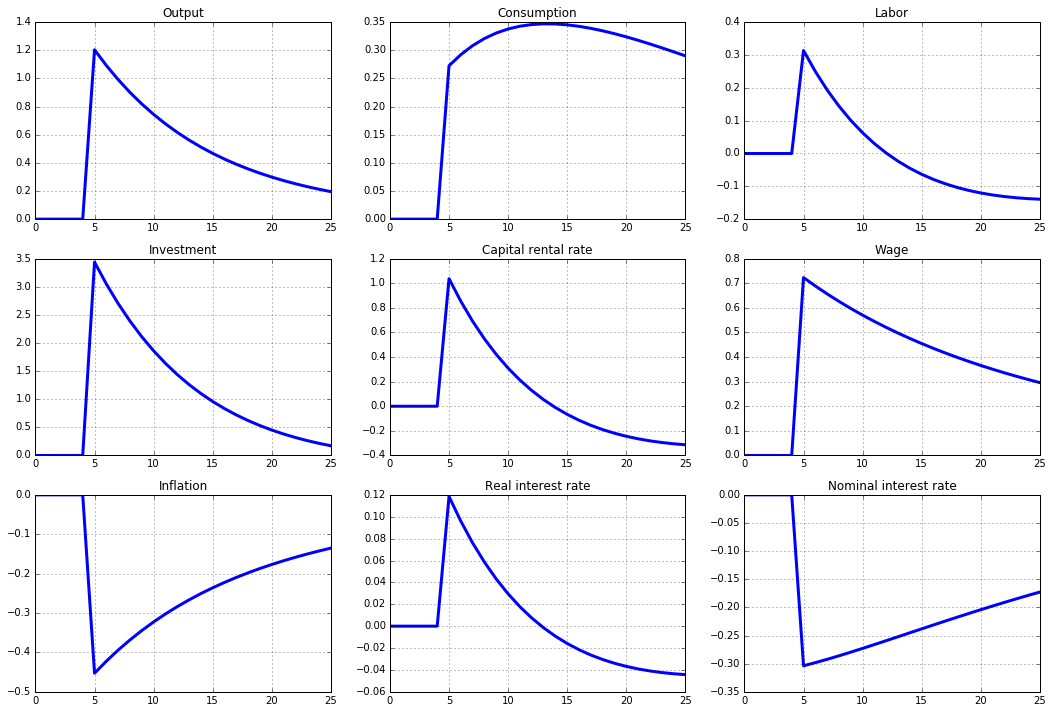

In [239]:
shock = 'e_a'

fig = plt.figure(figsize=(18,12))

ax1 = fig.add_subplot(3,3,1)
ax2 = fig.add_subplot(3,3,2)
ax3 = fig.add_subplot(3,3,3)
ax4 = fig.add_subplot(3,3,4)
ax5 = fig.add_subplot(3,3,5)
ax6 = fig.add_subplot(3,3,6)
ax7 = fig.add_subplot(3,3,7)
ax8 = fig.add_subplot(3,3,8)
ax9 = fig.add_subplot(3,3,9)


model.irs[shock]['y'].plot(lw=3,grid=True,ax=ax1,title='Output')
model.irs[shock]['c'].plot(lw=3,grid=True,ax=ax2,title='Consumption')
model.irs[shock]['l'].plot(lw=3,grid=True,ax=ax3,title='Labor')
model.irs[shock]['i'].plot(lw=3,grid=True,ax=ax4,title='Investment')
model.irs[shock]['r'].plot(lw=3,grid=True,ax=ax5,title='Capital rental rate')
model.irs[shock]['w'].plot(lw=3,grid=True,ax=ax6,title='Wage')
(model.irs[shock]['pi']*4).plot(lw=3,grid=True,ax=ax7,title='Inflation')
(model.irs[shock]['real_rate']*4).plot(lw=3,grid=True,ax=ax8,title='Real interest rate')
(model.irs[shock]['nominal_rate']*4).plot(lw=3,grid=True,ax=ax9,title='Nominal interest rate')


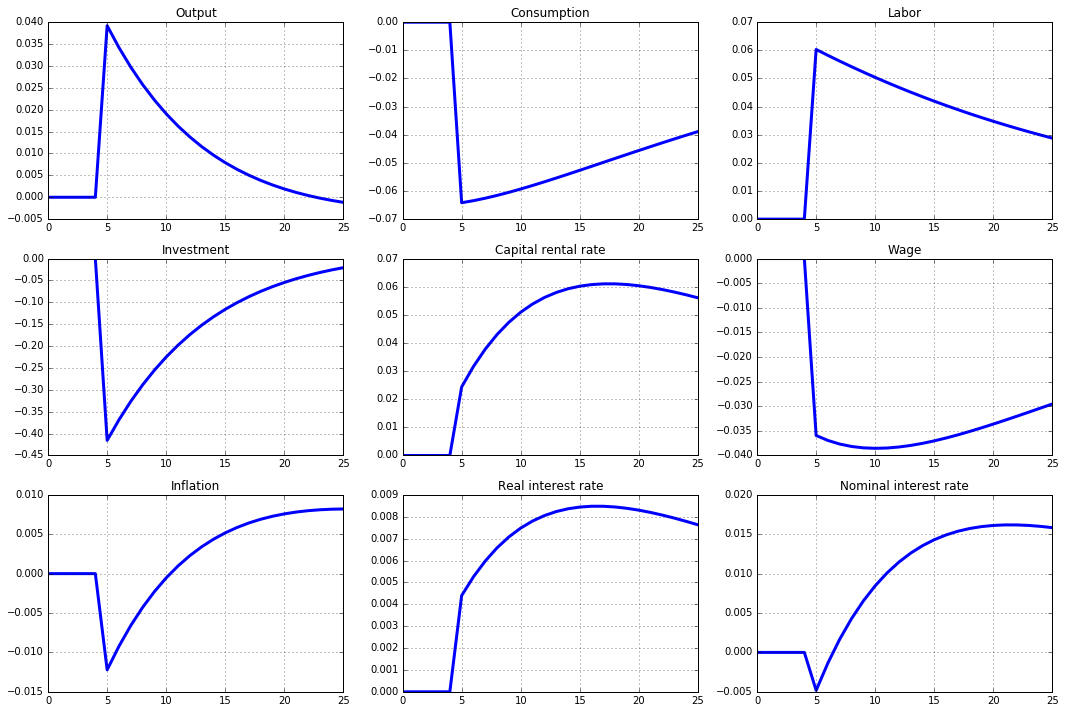

In [240]:
shock = 'e_g'

fig = plt.figure(figsize=(18,12))

ax1 = fig.add_subplot(3,3,1)
ax2 = fig.add_subplot(3,3,2)
ax3 = fig.add_subplot(3,3,3)
ax4 = fig.add_subplot(3,3,4)
ax5 = fig.add_subplot(3,3,5)
ax6 = fig.add_subplot(3,3,6)
ax7 = fig.add_subplot(3,3,7)
ax8 = fig.add_subplot(3,3,8)
ax9 = fig.add_subplot(3,3,9)


model.irs[shock]['y'].plot(lw=3,grid=True,ax=ax1,title='Output')
model.irs[shock]['c'].plot(lw=3,grid=True,ax=ax2,title='Consumption')
model.irs[shock]['l'].plot(lw=3,grid=True,ax=ax3,title='Labor')
model.irs[shock]['i'].plot(lw=3,grid=True,ax=ax4,title='Investment')
model.irs[shock]['r'].plot(lw=3,grid=True,ax=ax5,title='Capital rental rate')
model.irs[shock]['w'].plot(lw=3,grid=True,ax=ax6,title='Wage')
(model.irs[shock]['pi']*4).plot(lw=3,grid=True,ax=ax7,title='Inflation')
(model.irs[shock]['real_rate']*4).plot(lw=3,grid=True,ax=ax8,title='Real interest rate')
(model.irs[shock]['nominal_rate']*4).plot(lw=3,grid=True,ax=ax9,title='Nominal interest rate')


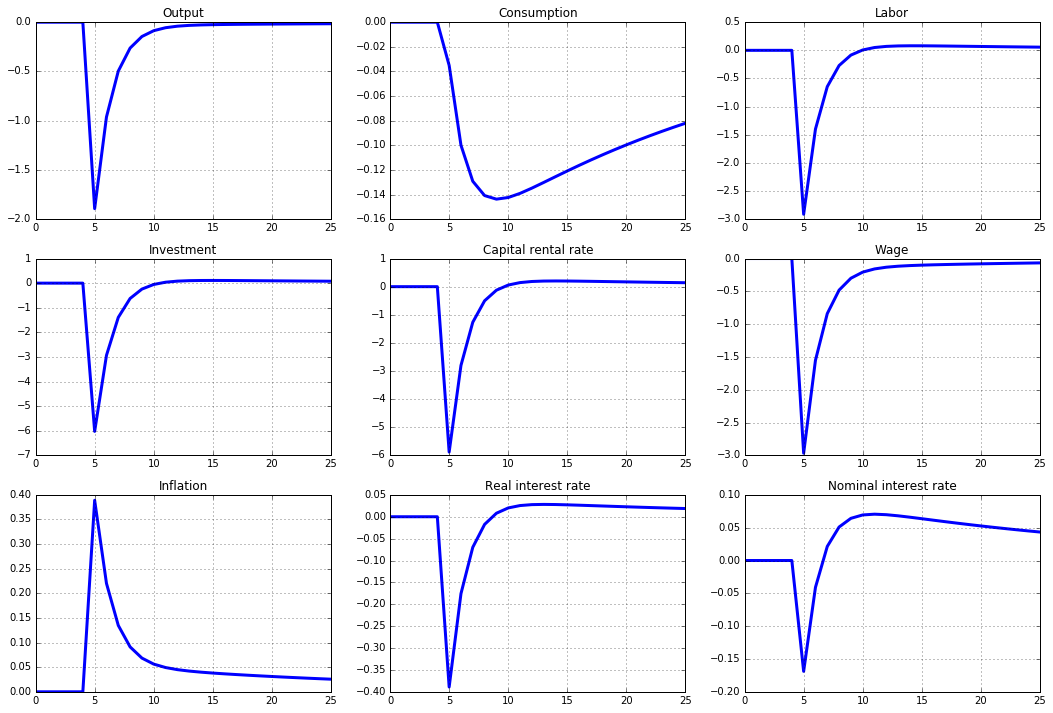

In [241]:
shock = 'e_u'

fig = plt.figure(figsize=(18,12))

ax1 = fig.add_subplot(3,3,1)
ax2 = fig.add_subplot(3,3,2)
ax3 = fig.add_subplot(3,3,3)
ax4 = fig.add_subplot(3,3,4)
ax5 = fig.add_subplot(3,3,5)
ax6 = fig.add_subplot(3,3,6)
ax7 = fig.add_subplot(3,3,7)
ax8 = fig.add_subplot(3,3,8)
ax9 = fig.add_subplot(3,3,9)


model.irs[shock]['y'].plot(lw=3,grid=True,ax=ax1,title='Output')
model.irs[shock]['c'].plot(lw=3,grid=True,ax=ax2,title='Consumption')
model.irs[shock]['l'].plot(lw=3,grid=True,ax=ax3,title='Labor')
model.irs[shock]['i'].plot(lw=3,grid=True,ax=ax4,title='Investment')
model.irs[shock]['r'].plot(lw=3,grid=True,ax=ax5,title='Capital rental rate')
model.irs[shock]['w'].plot(lw=3,grid=True,ax=ax6,title='Wage')
(model.irs[shock]['pi']*4).plot(lw=3,grid=True,ax=ax7,title='Inflation')
(model.irs[shock]['real_rate']*4).plot(lw=3,grid=True,ax=ax8,title='Real interest rate')
(model.irs[shock]['nominal_rate']*4).plot(lw=3,grid=True,ax=ax9,title='Nominal interest rate')


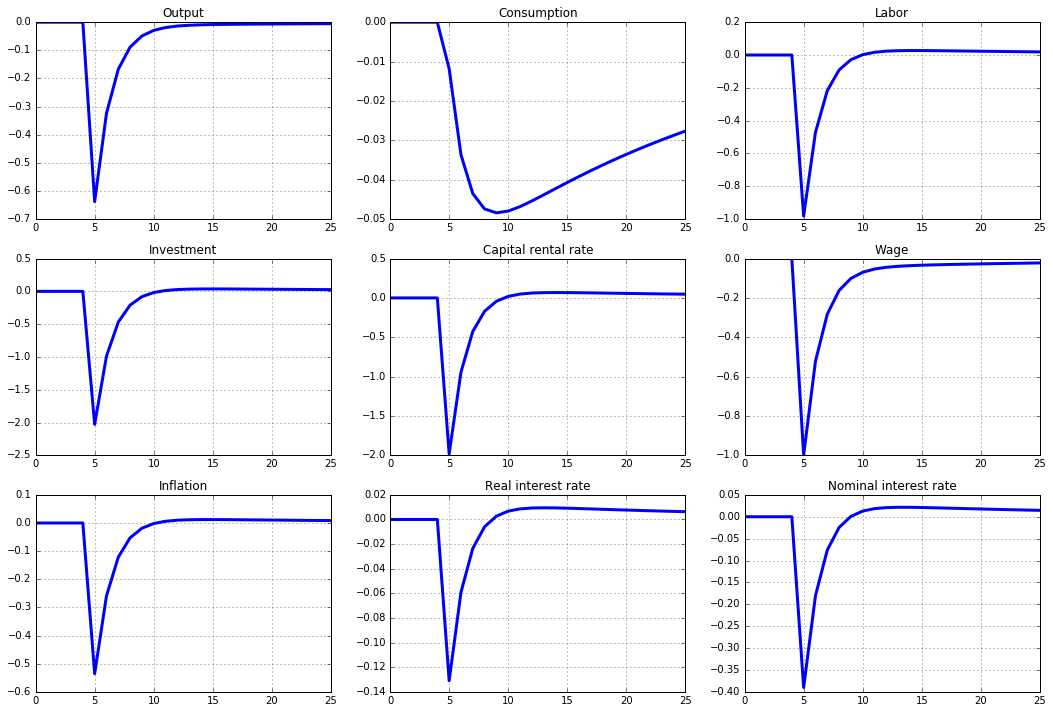

In [242]:
shock = 'e_v'

fig = plt.figure(figsize=(18,12))

ax1 = fig.add_subplot(3,3,1)
ax2 = fig.add_subplot(3,3,2)
ax3 = fig.add_subplot(3,3,3)
ax4 = fig.add_subplot(3,3,4)
ax5 = fig.add_subplot(3,3,5)
ax6 = fig.add_subplot(3,3,6)
ax7 = fig.add_subplot(3,3,7)
ax8 = fig.add_subplot(3,3,8)
ax9 = fig.add_subplot(3,3,9)


model.irs[shock]['y'].plot(lw=3,grid=True,ax=ax1,title='Output')
model.irs[shock]['c'].plot(lw=3,grid=True,ax=ax2,title='Consumption')
model.irs[shock]['l'].plot(lw=3,grid=True,ax=ax3,title='Labor')
model.irs[shock]['i'].plot(lw=3,grid=True,ax=ax4,title='Investment')
model.irs[shock]['r'].plot(lw=3,grid=True,ax=ax5,title='Capital rental rate')
model.irs[shock]['w'].plot(lw=3,grid=True,ax=ax6,title='Wage')
(model.irs[shock]['pi']*4).plot(lw=3,grid=True,ax=ax7,title='Inflation')
(model.irs[shock]['real_rate']*4).plot(lw=3,grid=True,ax=ax8,title='Real interest rate')
(model.irs[shock]['nominal_rate']*4).plot(lw=3,grid=True,ax=ax9,title='Nominal interest rate')


In [225]:
model.irs['e_v']

,e_v,k,a,g,u,v,nominal_rate,y,c,i,l,x,pi,real_rate,w,r
0,0.00,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,0.00,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,0.00,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,0.00,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4,0.00,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
5,0.25,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,2.500000e-01,-0.118253,-2.665923,-0.117825,-8.370896,-4.101420,3.604032,-0.023342,-0.094911,-2.168535,-6.269955
6,0.00,-0.209272,-1.609959e-16,-1.403886e-16,-8.819803e-18,1.250000e-01,-0.039975,-1.255291,-0.212737,-3.695081,-1.818531,1.685243,-0.005375,-0.034599,-1.122002,-2.731261
7,0.00,-0.296418,-2.253942e-16,-1.965441e-16,-8.819803e-18,6.250000e-02,-0.002436,-0.556466,-0.247336,-1.398159,-0.696492,0.735608,0.003082,-0.005517,-0.595582,-0.995656
8,0.00,-0.323961,-2.431038e-16,-2.119868e-16,-6.614852e-18,3.125000e-02,0.014866,-0.213003,-0.252853,-0.287257,-0.153256,0.269735,0.006828,0.008039,-0.329481,-0.158776
9,0.00,-0.323044,-2.389179e-16,-2.083367e-16,-4.409901e-18,1.562500e-02,0.022173,-0.046723,-0.244815,0.233774,0.102065,0.044995,0.008259,0.013914,-0.193782,0.231326


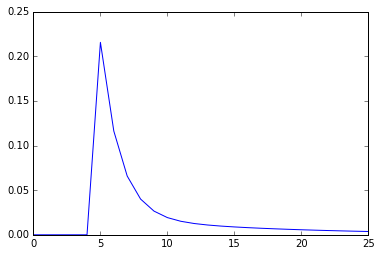

In [211]:
(model.irs['e_v']['pi']*1.5/1.005 + model.irs['e_v']['v']/1.005).plot()

In [212]:
print(model.approximated())

Log-linear equilibrium conditions:

                -1.7013·c[t+1|t] = -1.7013·c[t]-1.7013·real_rate[t]

                               0 = -4.9908·c[t]-2.4954·l[t]+4.9908·w[t]

-1.7013·c[t+1|t]+0.0591·r[t+1|t] = -1.7013·c[t]

                               0 = -2.9334·y[t]+2.9334·l[t]+2.9334·x[t]+2.9334·w[t]

                               0 = 0.0351·k[t]-0.0351·y[t]+0.0351·x[t]+0.0351·r[t]

                               0 = -0.4212·k[t]-1.2035·a[t]+1.2035·y[t]-0.7823·l[t]

                               0 = -0.2407·g[t]+1.2035·y[t]-0.5878·c[t]-0.375·i[t]

                               0 = -1.0101·v[t]+1.0101·nominal_rate[t]-0.1263·y[t]-1.5152·pi[t]

               -1.0101·pi[t+1|t] = -1.0101·nominal_rate[t]+1.0101·real_rate[t]

                  0.99·pi[t+1|t] = -u[t]+0.005·x[t]+pi[t]

                    -15.0·k[t+1] = -14.625·k[t]-0.375·i[t]

                         -g[t+1] = -0.9·g[t]

                         -a[t+1] = -0.9·a[t]

                         -u[t+1] = -0.5·u[t]

 

In [213]:
1.005*model.irs['e_v'].nominal_rate-1.5*model.irs['e_v'].pi + -model.irs['e_v'].v


0     0.000000
1     0.000000
2     0.000000
3     0.000000
4     0.000000
5    -0.311625
6    -0.147379
7    -0.065940
8    -0.025849
9    -0.006382
10    0.002821
11    0.006935
12    0.008543
13    0.008936
14    0.008753
15    0.008314
16    0.007775
17    0.007212
18    0.006661
19    0.006137
20    0.005648
21    0.005194
22    0.004774
23    0.004388
24    0.004033
25    0.003706
dtype: float64

In [214]:
print(model.solved())

Solution to the log-linear system:

         k[t+1] = 0.9189·k[t]-0.0253·a[t]-0.0141·g[t]-1.5482·u[t]-0.7818·v[t]+e_k[t+1]

         a[t+1] = 0.9·a[t]+e_a[t+1]

         g[t+1] = 0.9·g[t]+e_g[t+1]

         u[t+1] = 0.5·u[t]+e_u[t+1]

         v[t+1] = 0.5·v[t]+e_v[t+1]

nominal_rate[t] = -0.086·k[t]-0.1387·a[t]-0.0027·g[t]+0.2414·u[t]-0.3781·v[t]

           y[t] = -0.3418·k[t]-0.0967·a[t]-0.0134·g[t]-19.7166·u[t]-9.9569·v[t]

           c[t] = 0.7331·k[t]+0.4489·a[t]-0.0781·g[t]-0.8596·u[t]-0.4341·v[t]

           i[t] = -2.2459·k[t]-1.0139·a[t]-0.5624·g[t]-61.9279·u[t]-31.2736·v[t]

           l[t] = -1.0642·k[t]-1.6872·a[t]-0.0206·g[t]-30.3333·u[t]-15.3183·v[t]

           x[t] = 0.5215·k[t]+1.9853·a[t]+0.0956·g[t]+26.6429·u[t]+13.4546·v[t]

          pi[t] = -0.0289·k[t]-0.0844·a[t]-0.0007·g[t]+1.804·u[t]-0.089·v[t]

   real_rate[t] = -0.0595·k[t]-0.0635·a[t]-0.0025·g[t]-0.7053·u[t]-0.3562·v[t]

           w[t] = 0.201·k[t]-0.3947·a[t]-0.0884·g[t]-16.0262·u[t]-8.0932·v[t]

       

In [215]:
0.6079/1.0723

0.5669122447076378

In [216]:
0.25/1.0723

0.23314370978271007

In [57]:
model.ss.y*model.irs['e_v']['y'] - model.ss.c*model.irs['e_v']['c'] - model.ss.i*model.irs['e_v']['i']

0     0.000000e+00
1     0.000000e+00
2     0.000000e+00
3     0.000000e+00
4     0.000000e+00
5    -2.220446e-15
6     1.665335e-16
7     1.457168e-16
8     1.457168e-16
9     1.318390e-16
10    1.110223e-16
11    8.326673e-17
12    6.245005e-17
13    7.632783e-17
14    6.938894e-17
15    4.857226e-17
16    4.163336e-17
17    3.469447e-17
18    2.775558e-17
19    2.081668e-17
20    3.122502e-17
21    2.428613e-17
22    1.040834e-17
23    1.040834e-17
24    6.938894e-18
25    6.938894e-18
dtype: float64

## Solution

In [22]:
# Create a variable called 'parameters' that stores the model parameter values in a Pandas Series. CELL PROVIDED
parameters = pd.Series()
parameters['y_bar'] = 0
parameters['beta'] = 0.995
parameters['r_bar'] = -np.log(parameters.beta)
parameters['kappa'] = 0.1
parameters['pi_T'] = 0.02/4
parameters['phi_pi'] = 1.5
parameters['phi_y'] = 0.5/4
parameters['rho_g'] = 0.5
parameters['rho_u'] = 0.5
parameters['rho_v'] = 0.5

# Create variable called 'varNames' that stores the variable names in a list with state variables ordered first
varNames = ['g','u','v','y','pi','i','r']

# Create variable called 'shockNames' that stores an exogenous shock name for each state variable.
shockNames = ['e_g','e_u','e_v']

# Define a function that evaluates the equilibrium conditions of the model solved for zero.
def equilibrium_equations(variables_forward,variables_current,parameters):
    
    # Parameters
    p = parameters
    
    # Current variables
    cur = variables_current
    
    # Forward variables
    fwd = variables_forward

    # IS equation
    is_equation = fwd.y - (cur.r -p.r_bar) + cur.g - cur.y
    
    # Fisher_equation
    fisher_equation = cur.r + fwd.pi - cur.i
    
    # Monetary policy
    monetary_policy = p.r_bar + p.pi_T + p.phi_pi*(cur.pi - p.pi_T) + p.phi_y*cur.y + cur.v - cur.i
    
    # Phillips curve
    phillips_curve = p.beta*(fwd.pi- p.pi_T) + p.kappa*cur.y + cur.u - (cur.pi-p.pi_T)
    
    # Demand process
    demand_process = p.rho_g*cur.g - fwd.g
    
    # Monetary policy process
    monetary_policy_process = p.rho_v*cur.v - fwd.v
    
    # Inflation process
    inflation_process = p.rho_u*cur.u - fwd.u
    
    
    # Stack equilibrium conditions into a numpy array
    return np.array([
            is_equation,
            fisher_equation,
            monetary_policy,
            phillips_curve,
            demand_process,
            monetary_policy_process,
            inflation_process
        ])

# Initialize the model into a variable named 'nk_model'
nk_model = ls.model(equations = equilibrium_equations,
                 nstates=3,
                 varNames=varNames,
                 shockNames=shockNames,
                 parameters = parameters)


# Compute the steady state numerically using .compute_ss() method of nk_model
guess = [k,a,g,y,c,i,l,x,pi,real,nominal_rate,w,r]
nk_model.compute_ss(guess)

NameError: name 'real' is not defined

In [ ]:
# Find the log-linear approximation around the non-stochastic steady state and solve using .approximate_and_solve() method of nk_model
# set argumement 'loglinear' to False
nk_model.approximate_and_solve(loglinear=False)

# Print the solution to the model
print(nk_model.solved())

**Questions** 

1. Will a positive shock to $g_t$ increase or decrease $y_t$?
2. Will a positive shock to $g_t$ increase or decrease $\pi_t$?
3. Will a positive shock to $u_t$ increase or decrease $y_t$?
4. Will a positive shock to $u_t$ increase or decrease $\pi_t$?

**Answers**

1. The coefficient on $g_t$ in the solution for $y_t$ is *positive* so the shock will *increase* $y_t$ <!-- answer -->
2. The coefficient on $g_t$ in the solution for $\pi_t$ is *positive* so the shock will *increase* $\pi_t$ <!-- answer -->
1. The coefficient on $u_t$ in the solution for $y_t$ is *negative* so the shock will *decrease* $y_t$ <!-- answer -->
4. The coefficient on $u_t$ in the solution for $\pi_t$ is *positive* so the shock will *increase* $\pi_t$ <!-- answer -->

## Impulse Responses

Compute a 21 period impulse response of the model's variables to a:

* 0.01 unit shock to $g_t$
* 0.01/4 unit shock to $u_t$
* 0.01/4 unit shock to $v_t$

In [ ]:
# Compute impulse responses
nk_model.impulse(T=21,t0=5,shocks=[0.01,0.01/4,0.01/4])

### Demand Shock

Plot the computed impulses responses of the nominal_rate interest rate, the real interest rate, output, and inflation to the 0.01 unit demand shock. Express inflation and interest rates in *annualized* (e.g., multiplied by 4) terms.

In [ ]:
# Create figure. PROVIDED
fig = plt.figure(figsize=(12,8))

# Create upper-left axis. PROVIDED
ax1 = fig.add_subplot(2,2,1)
(nk_model.irs['e_g']['i']*400).plot(ax=ax1,lw=3,alpha=0.75,title='nominal_rate Interest',grid=True)
ax1.set_ylabel('% dev from steady state')

# Create upper-right axis. PROVIDED
ax2 = fig.add_subplot(2,2,2)
(nk_model.irs['e_g']['r']*400).plot(ax=ax2,lw=3,alpha=0.75,title='Real Interest',grid=True)
ax2.set_ylabel('% dev from steady state')

# Create lower-left axis. PROVIDED
ax3 = fig.add_subplot(2,2,3)
(nk_model.irs['e_g']['y']*100).plot(ax=ax3,lw=3,alpha=0.75,title='Output',grid=True)
ax3.set_ylabel('% dev from steady state')

# Create lower-right axis. PROVIDED
ax4 = fig.add_subplot(2,2,4)
(nk_model.irs['e_g']['pi']*400).plot(ax=ax4,lw=3,alpha=0.75,title='Inflation',grid=True)
ax4.set_ylabel('% dev from steady state')

ax1.set_ylim([-0.5,2.5])
ax2.set_ylim([-0.5,2.5])
ax3.set_ylim([-0.5,1.5])
ax4.set_ylim([-0.5,1.5])

fig.tight_layout()

### Inflation Shock

Plot the computed impulses responses of the nominal_rate interest rate, the real interest rate, output, and inflation to the 0.01/4 unit inflation shock. Express inflation and interest rates in *annualized* (e.g., multiplied by 4) terms.

In [ ]:
# Create figure. PROVIDED
fig = plt.figure(figsize=(12,8))

# Create upper-left axis. PROVIDED
ax1 = fig.add_subplot(2,2,1)
(nk_model.irs['e_u']['i']*400).plot(ax=ax1,lw=3,alpha=0.75,title='nominal_rate Interest',grid=True)
ax1.set_ylabel('% dev from steady state')

# Create upper-right axis. PROVIDED
ax2 = fig.add_subplot(2,2,2)
(nk_model.irs['e_u']['r']*400).plot(ax=ax2,lw=3,alpha=0.75,title='Real Interest',grid=True)
ax2.set_ylabel('% dev from steady state')

# Create lower-left axis. PROVIDED
ax3 = fig.add_subplot(2,2,3)
(nk_model.irs['e_u']['y']*100).plot(ax=ax3,lw=3,alpha=0.75,title='Output',grid=True)
ax3.set_ylabel('% dev from steady state')

# Create lower-right axis. PROVIDED
ax4 = fig.add_subplot(2,2,4)
(nk_model.irs['e_u']['pi']*400).plot(ax=ax4,lw=3,alpha=0.75,title='Inflation',grid=True)
ax4.set_ylabel('% dev from steady state')

ax1.set_ylim([-.5,2.5])
ax2.set_ylim([-0.5,2.5])
ax3.set_ylim([-1,0.5])
ax4.set_ylim([-0.5,2])

fig.tight_layout()

### Monetary Policy Shock

Plot the computed impulses responses of the nominal_rate interest rate, the real interest rate, output, and inflation to the 0.01/4 unit monetary policy shock. Express inflation and interest rates in *annualized* (e.g., multiplied by 4) terms.

In [ ]:
# Create figure. PROVIDED
fig = plt.figure(figsize=(12,8))

# Create upper-left axis. PROVIDED
ax1 = fig.add_subplot(2,2,1)
(nk_model.irs['e_v']['i']*400).plot(ax=ax1,lw=3,alpha=0.75,title='nominal_rate Interest',grid=True)
ax1.set_ylabel('% dev from steady state')

# Create upper-right axis. PROVIDED
ax2 = fig.add_subplot(2,2,2)
(nk_model.irs['e_v']['r']*400).plot(ax=ax2,lw=3,alpha=0.75,title='Real Interest',grid=True)
ax2.set_ylabel('% dev from steady state')

# Create lower-left axis. PROVIDED
ax3 = fig.add_subplot(2,2,3)
(nk_model.irs['e_v']['y']*100).plot(ax=ax3,lw=3,alpha=0.75,title='Output',grid=True)
ax3.set_ylabel('% dev from steady state')

# Create lower-right axis. PROVIDED
ax4 = fig.add_subplot(2,2,4)
(nk_model.irs['e_v']['pi']*400).plot(ax=ax4,lw=3,alpha=0.75,title='Inflation',grid=True)
ax4.set_ylabel('% dev from steady state')

ax1.set_ylim([-0.2,0.8])
ax2.set_ylim([-0.2,0.8])
ax3.set_ylim([-0.4,0.1])
ax4.set_ylim([-0.4,0.1])

fig.tight_layout()